In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import string
from datetime import datetime, timedelta

from pyspark.sql.functions import coalesce, lit, rand, col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegressionModel, RandomForestClassificationModel
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
import pyspark.sql.utils

In [ ]:
packages = [
    'org.apache.hadoop:hadoop-aws:3.3.4',
    'org.apache.hadoop:hadoop-client-api:3.3.4',
    'org.apache.hadoop:hadoop-client-runtime:3.3.4',
]

conf = SparkConf() \
    .setAppName("MyApp") \
    .set("spark.driver.memory", "8g") \
    .set("spark.executor.memory", "8g") \
    .set('spark.jars.packages', ','.join(packages))

sc = SparkContext(conf=conf)

hadoop_config = sc._jsc.hadoopConfiguration()
hadoop_config.set('fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem')
hadoop_config.set('com.amazonaws.services.s3.enableV4', 'true')

spark = SparkSession(sc)

In [11]:
class LogisticRegressionTrial:

    def __init__(self, data, seed):
        # Split the data into training and test sets (80% training, 20% test)
        self.train_data, self.test_data = data.randomSplit([0.8, 0.2], seed)
        
        # String Indexing for features
        self.indexers = [
            StringIndexer(inputCol="label", outputCol="label_index"),
            StringIndexer(inputCol="color", outputCol="color_index"),
            StringIndexer(inputCol="type", outputCol="type_index"),
            StringIndexer(inputCol="localHour", outputCol="localHour_index"),
            StringIndexer(inputCol="dayOfWeek", outputCol="dayOfWeek_index"),
        ]
        
        # One-Hot Encoding for Logistic Regression (not needed for tree-based models)
        self.encoder = OneHotEncoder(
            inputCols=["color_index", "type_index", "localHour_index", "dayOfWeek_index"],
            outputCols=["color_vec", "type_vec", "localHour_vec", "dayOfWeek_vec"]
        )

        self.assembler_lr_nb = VectorAssembler(
            inputCols=["type_vec", "color_vec", "localHour_vec", "milesperhour", "age", "dayOfWeek_vec"],
            outputCol="assembled_features"
        )
    
        # MinMaxScaler for Logistic Regression and Naive Bayes
        self.scaler_lr_nb = MinMaxScaler(inputCol="assembled_features", outputCol="features")
        
        # Create and Fit the Pipeline for Logistic Regression and Naive Bayes
        self.pipeline_lr_nb = Pipeline(stages=self.indexers + [self.encoder, self.assembler_lr_nb, self.scaler_lr_nb])
        self.model_lr_nb = self.pipeline_lr_nb.fit(self.train_data)
        self.transformed_train_data_lr_nb = self.model_lr_nb.transform(self.train_data)
        self.transformed_test_data_lr_nb = self.model_lr_nb.transform(self.test_data)

        self.lr = LogisticRegression(featuresCol="features", labelCol="label_index")
        self.lr_model = None
    
    def get_labels(self):
        return self.model_lr_nb.stages[0].labels

    def get_features(self):
        if 'assembled_features' in self.transformed_train_data_lr_nb.schema.names:
            feature_attrs = self.transformed_train_data_lr_nb.schema['assembled_features'].metadata['ml_attr']['attrs']
        else:
            feature_attrs = self.transformed_train_data_lr_nb.schema['features'].metadata['ml_attr']['attrs']
    
        features = []
        for attr_type, attrs in feature_attrs.items():
            features += attrs
    
        # for each in sorted(features, key=lambda x: x['idx']):
        #     print(each['idx'], each['name'])
        
        feature_names = [each['name'] for each in sorted(features, key=lambda x: x['idx'])]
    
        return feature_names

    def run(self):
        # Training the Logistic Regression Model
        self.lr_model = self.lr.fit(self.transformed_train_data_lr_nb)

        # Get model coefficients and intercept for Logistic Regression
        coefficients = self.lr_model.coefficientMatrix
        intercept = self.lr_model.interceptVector
        print(f"Coefficients: {coefficients}")
        print(f"Intercept: {intercept}")

        coef_df = pd.DataFrame(
            np.array(coefficients.toArray().tolist()),
            columns=self.get_features()
        )
        
        coef_df['label'] = self.get_labels()
        coef_df[['label'] + list(coef_df.columns)[:-1]].sort_values(by="label")
        coef_df2 = coef_df.reset_index(drop=True).melt(id_vars=['label'], var_name='feature', value_name='coefficient')
        coef_df2[['label', 'feature', 'coefficient']].sort_values(by=['label', 'feature'])
        coeff_pd_df = coef_df2.rename(columns={"feature": "Feature", "coefficient": "Coefficient"})

        local_hour_mappings = {f"localHour_vec_{i}": f"localHour_vec_{i:02d}" for i in range(1, 24)}
        days_of_week = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
        day_of_week_mappingss = {f"dayOfWeek_vec_{day}": f"dayOfWeek_vec_{i}{day}" for i, day in enumerate(days_of_week)}
        feature_mappings = {**local_hour_mappings, **day_of_week_mappingss}
        
        # # Get unique sorted columb values
        unique_columnb_values = sorted(coeff_pd_df['label'].unique())
        
        # Create a dictionary to hold the data for the new
        data_dict = {'Feature': []}
        for b_value in unique_columnb_values:
            data_dict[f'label={b_value}'] = []
        
        # Populate the dictionary
        unique_columna_values = coeff_pd_df['Feature'].unique()
        for a_value in unique_columna_values:
            data_dict['Feature'].append(a_value)
            for b_value in unique_columnb_values:
                if a_value in coeff_pd_df[coeff_pd_df['label'] == b_value]['Feature'].values:
                    data_dict[f'label={b_value}'].append(coeff_pd_df[(coeff_pd_df['label'] == b_value) & (coeff_pd_df['Feature'] == a_value)]['Coefficient'].values[0])
                else:
                    data_dict[f'label={b_value}'].append(None)
        
        # Create the new DataFrame
        top5_df = pd.DataFrame(data_dict)
        
        top5_df['Feature_alias'] = top5_df.Feature.apply(lambda feature_name: feature_mappings.get(feature_name, feature_name))
        
        # Display the DataFrame
        top5_df.sort_values(by="Feature_alias").drop(columns=["Feature_alias"])

        self.coeff_df = top5_df
    
    def save_models(self, pipeline_model_path, lr_model_path):
        self.model_lr_nb.write().overwrite().save(pipeline_model_path)
        self.lr_model.write().overwrite().save(lr_model_path)

    def load_models(self, pipeline_model_path, lr_model_path):
        self.model_lr_nb =  PipelineModel.load(pipeline_model_path)
        self.lr_model = LogisticRegressionModel.load(lr_model_path)

In [12]:
def load_or_create_coeff_df(save_path):
    try:
        # すでに保存済みのファイルがあれば読み込む
        saved_coeff_df = spark.read.parquet(save_path).toPandas()
        print("loaded")
        return saved_coeff_df
    except pyspark.sql.utils.AnalysisException:
        print("no data")
        return pd.DataFrame()

In [19]:
# string label
data = spark.createDataFrame([
    (0, "red",   "SUV",   12, 20.0, 60, "class1", "2024-07-01", "u4pruydqqvj", "Sunday"),
    (1, "red",   "sedan",  9, 30.0, 70, "class2", "2024-07-02", "u4pruydqqvk", "Friday"),
    (2, "red",   "truck", 15, 25.0, 80, "class3", "2024-07-01", "u4pruydqqvj", "Sunday"),
    (3, "blue",  "SUV",   20, 22.0, 65, "class1", "2024-07-02", "u4pruydqqvk", "Monday"),
    (4, "blue",  "sedan",  5, 35.0, 75, "class1", "2024-07-01", "u4pruydqqvj", "Tuesday"),
    (5, "blue",  "truck", 12, 28.0, 85, "class3", "2024-07-02", "u4pruydqqvk", "Tuesday"),
    (6, "green", "SUV",    9, 19.0, 50, "class2", "2024-07-03", "u4pruydqqvl", "Sunday"),
    (7, "green", "sedan", 15, 32.0, 60, "class3", "2024-07-03", "u4pruydqqvm", "Thursday"),
    (8, "green", "truck", 20, 27.0, 40, "class1", "2024-07-04", "u4pruydqqvn", "Saturday"),
    (9, "green", "SUV",    5, 21.0, 55, "class2", "2024-07-04", "u4pruydqqvo", "Saturday")
], ["id", "color", "type", "localHour", "milesperhour", "age", "label", "date", "geohash", "dayOfWeek"])

num_trials = 5

# モデルを作ったときの結果の coefficient を保存するデータフレーム
# coeff_df_savepath = "./data/tmp/coeff_df/"
coeff_df_savepath = "s3://path/to/coeff_dfs.parquet"
coeff_df = load_or_create_coeff_df(coeff_df_savepath)

for trial_number in range(num_trials):
    print(trial_number)
    
    # 同じ trial_number で実行した結果があればスキップ
    if trial_number in coeff_df.trial.unique():
        print(f"{trial_number=} already exists")
        continue

    pipeline_model_path = f"pipelines/model_lr_nb/{trial_number}"
    lr_model_path = f"models/lr_model/{trial_number}"

    trial = LogisticRegressionTrial(data=data, seed=trial_number)
    trial.run()
    trial.save_models(pipeline_model_path=pipeline_model_path, lr_model_path=lr_model_path)

    # 今回の実行結果を coeff_df に追記して保存
    current_coeff_df = trial.coeff_df.copy()
    current_coeff_df["trial"] = trial_number
    coeff_df = pd.concat([coeff_df, current_coeff_df])
    spark.createDataFrame(coeff_df).repartition(1).write.format("parquet").mode('overwrite').save(coeff_df_savepath)

loaded
0
trial_number=0 already exists
1
trial_number=1 already exists
2
trial_number=2 already exists
3
trial_number=3 already exists
4
trial_number=4 already exists


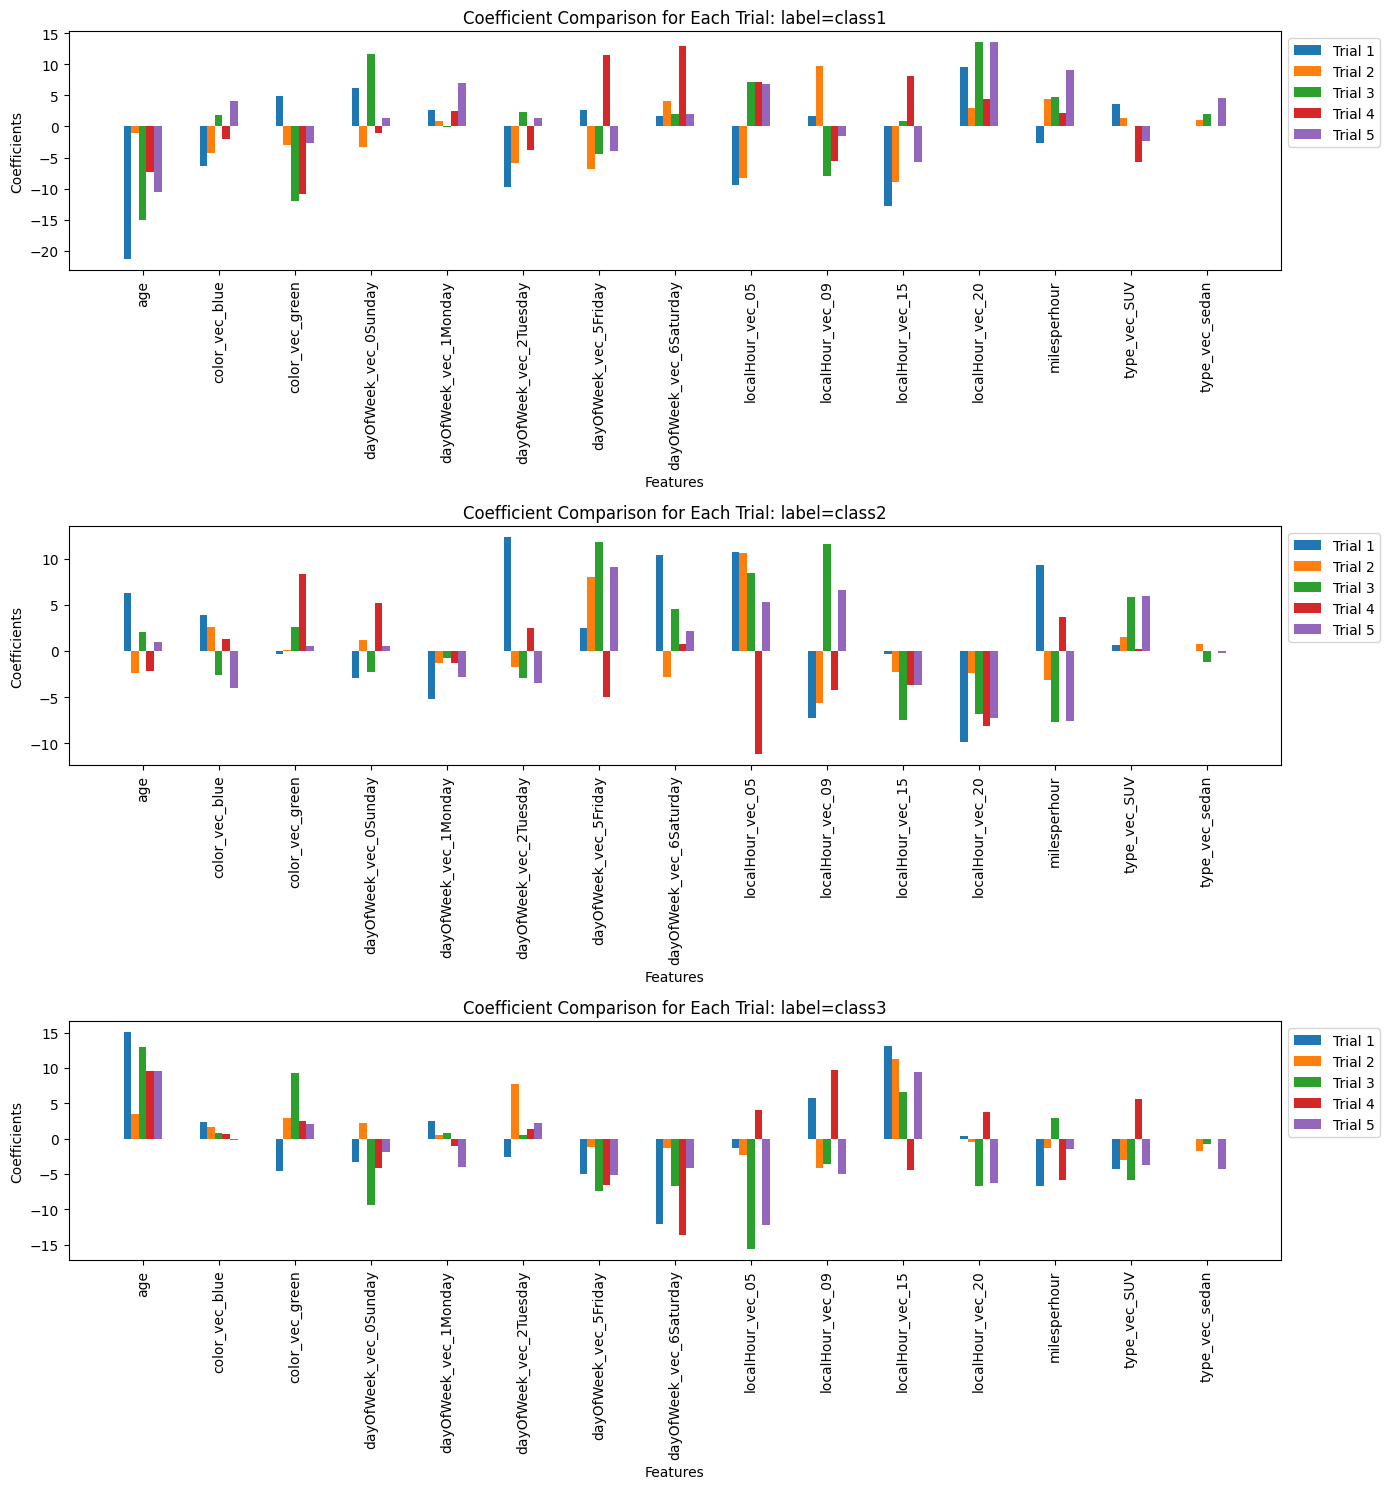

In [34]:
# ceoff_df の分析

# trial ごとにデータフレームを切り分ける
coeff_dfs = []
for trial in sorted(coeff_df.trial.unique()):
    coeff_dfs.append(coeff_df.loc[coeff_df.trial == trial].copy())

labels = [f"label={each.label}" for each in data.select(col("label")).distinct().collect()]

# Create a figure with subplots
fig, axes = plt.subplots(len(labels), 1, figsize=(14, len(labels) * 5))

# Plot each label's coefficients
for idx, label in enumerate(labels):
    ax = axes[idx]
    for i, df in enumerate(coeff_dfs):
        width = 0.1  # Width of the bars
        x = range(len(df))  # X locations for the groups
        ax.bar([p + width*i for p in x], df.sort_values(by="Feature_alias")[label], width=width, label=f'Trial {i+1}')
    
    # Add titles and labels
    ax.set_title(f'Coefficient Comparison for Each Trial: {label}')
    ax.set_xlabel('Features')
    ax.set_ylabel('Coefficients')
    ax.set_xticks([p + width*(len(coeff_dfs)/2 - 0.5) for p in x])

    ax.set_xticklabels(df.sort_values(by="Feature_alias")['Feature_alias'], rotation=90)

    # set xtickslabels only on the last plot
    # if idx < len(labels) - 1:
    #     ax.set_xticklabels([])
    # else:
    #     ax.set_xticklabels(df['Feature_alias'], rotation=90)

    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

# Save the plot to a file
plt.savefig('coefficients_comparison.png')